# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Extracting celeba...


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

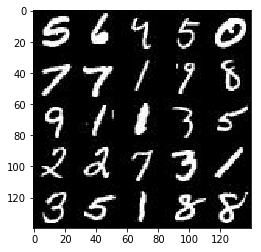

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

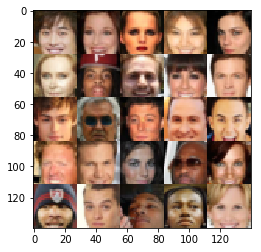

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='Real_Input')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='Z_input')
    learning_rate = tf.placeholder(tf.float32, name='Learning_Rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(0.2 * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, filters=128, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, filters=256, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        # 4x4x256
        
        #x4 = tf.layers.conv2d(relu3, filters=512, kernel_size=5, strides=2, padding='same')
        #bn4 = tf.layers.batch_normalization(x4, training=True)
        #relu4 = tf.maximum(0.2 * bn4, bn4)
        # 2x2x512
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        out = tf.sigmoid(logits)


    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        #x1 = tf.layers.dense(z, 2*2*512,activation=tf.nn.relu)
        x1 = tf.layers.dense(z, 7*7*512, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.01 * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.01 * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.01 * x3, x3)
        # 28x28x128 now

        #x4 = tf.layers.conv2d_transpose(x3, filters=64, kernel_size=5, strides=2, padding='same')
        #x4 = tf.layers.batch_normalization(x4, training=is_train)
        #x4 = tf.maximum(0.2 * x4, x4)
        # 14x14x64 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)

    
    return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #Generator生成图片
    g_model_out = generator(input_z,out_channel_dim,is_train=True)
    #real picture from discriminator
    d_real_out,d_real_logits = discriminator(input_real,reuse=False)
    #fake picture from discriminator
    d_fake_out,d_fake_logits = discriminator(g_model_out,reuse=True)
    
    # Generator loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,labels=tf.ones_like(d_fake_out)))
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits,
                                                                         labels=tf.ones_like(d_real_out)*0.9))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,labels=tf.zeros_like(d_fake_out)))
    # Discriminator loss (fake + real)
    d_loss = d_real_loss + d_fake_loss
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 100
    print_every = 10    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.1083... Generator Loss: 14.4602
Epoch 1/2... Discriminator Loss: 3.2240... Generator Loss: 0.0787
Epoch 1/2... Discriminator Loss: 0.6041... Generator Loss: 6.6351
Epoch 1/2... Discriminator Loss: 0.5561... Generator Loss: 2.2860
Epoch 1/2... Discriminator Loss: 1.2664... Generator Loss: 0.6247
Epoch 1/2... Discriminator Loss: 0.7606... Generator Loss: 3.8781
Epoch 1/2... Discriminator Loss: 0.6393... Generator Loss: 1.8758
Epoch 1/2... Discriminator Loss: 2.9034... Generator Loss: 11.0433
Epoch 1/2... Discriminator Loss: 0.5425... Generator Loss: 2.3516


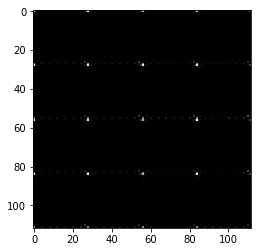

Epoch 1/2... Discriminator Loss: 0.7182... Generator Loss: 1.4339
Epoch 1/2... Discriminator Loss: 0.8738... Generator Loss: 1.4931
Epoch 1/2... Discriminator Loss: 1.4514... Generator Loss: 3.3558
Epoch 1/2... Discriminator Loss: 1.2837... Generator Loss: 0.8750
Epoch 1/2... Discriminator Loss: 1.5111... Generator Loss: 1.6080
Epoch 1/2... Discriminator Loss: 0.9824... Generator Loss: 1.4109
Epoch 1/2... Discriminator Loss: 0.9920... Generator Loss: 1.6212
Epoch 1/2... Discriminator Loss: 1.0672... Generator Loss: 0.7760
Epoch 1/2... Discriminator Loss: 1.2192... Generator Loss: 0.8093
Epoch 1/2... Discriminator Loss: 0.9807... Generator Loss: 1.4237


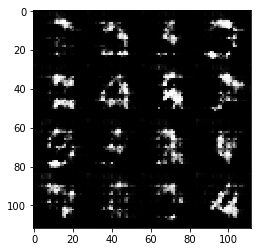

Epoch 1/2... Discriminator Loss: 1.3881... Generator Loss: 0.7863
Epoch 1/2... Discriminator Loss: 1.2976... Generator Loss: 0.6469
Epoch 1/2... Discriminator Loss: 1.1221... Generator Loss: 0.8009
Epoch 1/2... Discriminator Loss: 1.4615... Generator Loss: 0.6117
Epoch 1/2... Discriminator Loss: 1.3317... Generator Loss: 1.0539
Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 0.6776
Epoch 1/2... Discriminator Loss: 1.4677... Generator Loss: 2.4261
Epoch 1/2... Discriminator Loss: 1.0026... Generator Loss: 1.3139
Epoch 1/2... Discriminator Loss: 1.0440... Generator Loss: 1.3051
Epoch 1/2... Discriminator Loss: 1.1690... Generator Loss: 1.1663


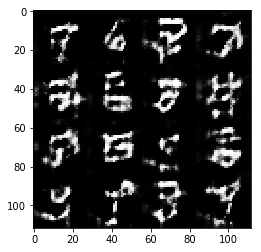

Epoch 1/2... Discriminator Loss: 1.1961... Generator Loss: 0.9459
Epoch 1/2... Discriminator Loss: 1.4985... Generator Loss: 1.1587
Epoch 1/2... Discriminator Loss: 1.1397... Generator Loss: 1.2116
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 0.7231
Epoch 1/2... Discriminator Loss: 1.4863... Generator Loss: 0.5555
Epoch 1/2... Discriminator Loss: 1.1853... Generator Loss: 0.9931
Epoch 1/2... Discriminator Loss: 1.3354... Generator Loss: 0.8755
Epoch 1/2... Discriminator Loss: 1.2988... Generator Loss: 0.7541
Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 0.6529
Epoch 1/2... Discriminator Loss: 1.5484... Generator Loss: 1.7442


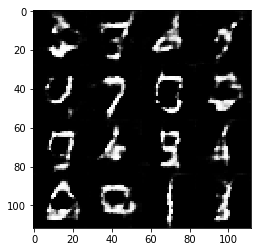

Epoch 1/2... Discriminator Loss: 1.1215... Generator Loss: 1.2680
Epoch 1/2... Discriminator Loss: 1.1547... Generator Loss: 1.2516
Epoch 1/2... Discriminator Loss: 1.1516... Generator Loss: 1.0553
Epoch 1/2... Discriminator Loss: 1.1287... Generator Loss: 0.9237
Epoch 1/2... Discriminator Loss: 1.8490... Generator Loss: 0.3005
Epoch 1/2... Discriminator Loss: 1.1041... Generator Loss: 0.9422
Epoch 1/2... Discriminator Loss: 1.2804... Generator Loss: 0.8521
Epoch 1/2... Discriminator Loss: 1.1683... Generator Loss: 0.9614
Epoch 1/2... Discriminator Loss: 1.1157... Generator Loss: 0.9792
Epoch 1/2... Discriminator Loss: 1.4280... Generator Loss: 0.5112


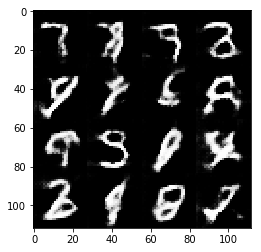

Epoch 1/2... Discriminator Loss: 1.4685... Generator Loss: 0.4776
Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 0.9189
Epoch 1/2... Discriminator Loss: 1.2077... Generator Loss: 0.8410
Epoch 1/2... Discriminator Loss: 1.1461... Generator Loss: 1.2817
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 1.1736
Epoch 1/2... Discriminator Loss: 1.3130... Generator Loss: 1.6057
Epoch 1/2... Discriminator Loss: 1.1816... Generator Loss: 1.1126
Epoch 1/2... Discriminator Loss: 1.1755... Generator Loss: 1.4217
Epoch 1/2... Discriminator Loss: 1.4708... Generator Loss: 0.4764
Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 1.0787


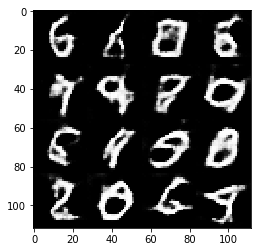

Epoch 1/2... Discriminator Loss: 1.2094... Generator Loss: 1.1875
Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 0.9206
Epoch 1/2... Discriminator Loss: 1.3108... Generator Loss: 0.6921
Epoch 1/2... Discriminator Loss: 1.3341... Generator Loss: 0.6557
Epoch 1/2... Discriminator Loss: 1.2383... Generator Loss: 1.1666
Epoch 1/2... Discriminator Loss: 1.0998... Generator Loss: 1.2215
Epoch 1/2... Discriminator Loss: 1.2666... Generator Loss: 0.6572
Epoch 1/2... Discriminator Loss: 1.4231... Generator Loss: 0.5273
Epoch 1/2... Discriminator Loss: 1.4052... Generator Loss: 1.6435
Epoch 1/2... Discriminator Loss: 1.1383... Generator Loss: 1.0223


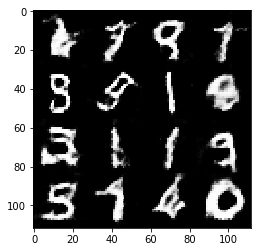

Epoch 1/2... Discriminator Loss: 1.3252... Generator Loss: 1.4532
Epoch 1/2... Discriminator Loss: 1.1940... Generator Loss: 0.8718
Epoch 1/2... Discriminator Loss: 1.3245... Generator Loss: 0.7382
Epoch 1/2... Discriminator Loss: 1.2039... Generator Loss: 1.0303
Epoch 1/2... Discriminator Loss: 1.1586... Generator Loss: 1.0036
Epoch 1/2... Discriminator Loss: 1.1740... Generator Loss: 0.8869
Epoch 1/2... Discriminator Loss: 1.3639... Generator Loss: 0.6163
Epoch 1/2... Discriminator Loss: 1.4633... Generator Loss: 0.5108
Epoch 1/2... Discriminator Loss: 1.3579... Generator Loss: 0.5654
Epoch 1/2... Discriminator Loss: 1.2909... Generator Loss: 1.0685


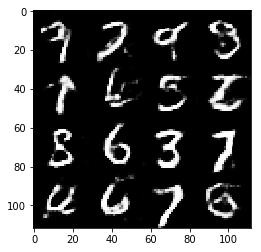

Epoch 1/2... Discriminator Loss: 1.4442... Generator Loss: 0.5066
Epoch 1/2... Discriminator Loss: 1.2142... Generator Loss: 1.2798
Epoch 1/2... Discriminator Loss: 1.1661... Generator Loss: 0.9160
Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 0.7656
Epoch 1/2... Discriminator Loss: 1.2503... Generator Loss: 0.7646
Epoch 1/2... Discriminator Loss: 1.2882... Generator Loss: 0.6901
Epoch 1/2... Discriminator Loss: 1.1362... Generator Loss: 1.0883
Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 1.4318
Epoch 1/2... Discriminator Loss: 1.2891... Generator Loss: 0.6247
Epoch 1/2... Discriminator Loss: 1.2872... Generator Loss: 0.6455


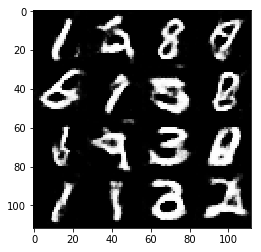

Epoch 1/2... Discriminator Loss: 1.2791... Generator Loss: 1.6144
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.5264
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.7885
Epoch 1/2... Discriminator Loss: 1.4682... Generator Loss: 0.6679
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.6772
Epoch 2/2... Discriminator Loss: 1.5135... Generator Loss: 0.4746
Epoch 2/2... Discriminator Loss: 1.3059... Generator Loss: 0.9274
Epoch 2/2... Discriminator Loss: 1.3482... Generator Loss: 0.6706
Epoch 2/2... Discriminator Loss: 1.3055... Generator Loss: 0.6752
Epoch 2/2... Discriminator Loss: 1.2693... Generator Loss: 0.8349


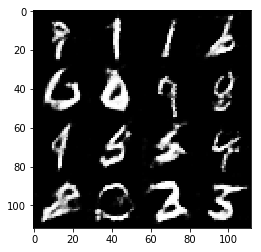

Epoch 2/2... Discriminator Loss: 1.2343... Generator Loss: 1.0684
Epoch 2/2... Discriminator Loss: 1.1672... Generator Loss: 0.9625
Epoch 2/2... Discriminator Loss: 1.2376... Generator Loss: 0.8467
Epoch 2/2... Discriminator Loss: 1.4429... Generator Loss: 1.5107
Epoch 2/2... Discriminator Loss: 1.0993... Generator Loss: 1.1763
Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 1.1202
Epoch 2/2... Discriminator Loss: 1.3330... Generator Loss: 1.0915
Epoch 2/2... Discriminator Loss: 1.2755... Generator Loss: 0.6836
Epoch 2/2... Discriminator Loss: 1.1794... Generator Loss: 1.0475
Epoch 2/2... Discriminator Loss: 1.4622... Generator Loss: 1.7033


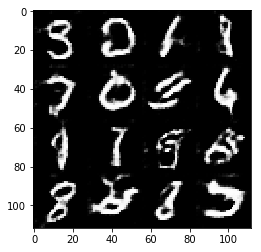

Epoch 2/2... Discriminator Loss: 1.2467... Generator Loss: 0.8117
Epoch 2/2... Discriminator Loss: 1.4431... Generator Loss: 0.4716
Epoch 2/2... Discriminator Loss: 1.1876... Generator Loss: 0.8838
Epoch 2/2... Discriminator Loss: 1.3527... Generator Loss: 0.5657
Epoch 2/2... Discriminator Loss: 1.2378... Generator Loss: 1.2666
Epoch 2/2... Discriminator Loss: 1.2084... Generator Loss: 0.8409
Epoch 2/2... Discriminator Loss: 1.2184... Generator Loss: 0.7759
Epoch 2/2... Discriminator Loss: 1.3620... Generator Loss: 1.6656
Epoch 2/2... Discriminator Loss: 1.3659... Generator Loss: 0.6819
Epoch 2/2... Discriminator Loss: 1.1628... Generator Loss: 1.0746


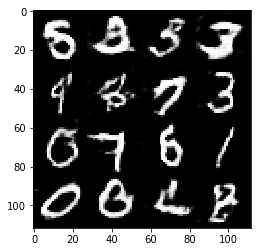

Epoch 2/2... Discriminator Loss: 1.3927... Generator Loss: 1.1857
Epoch 2/2... Discriminator Loss: 1.2378... Generator Loss: 1.3345
Epoch 2/2... Discriminator Loss: 1.1476... Generator Loss: 0.8212
Epoch 2/2... Discriminator Loss: 1.2358... Generator Loss: 0.6522
Epoch 2/2... Discriminator Loss: 1.3068... Generator Loss: 0.5770
Epoch 2/2... Discriminator Loss: 1.9962... Generator Loss: 0.2758
Epoch 2/2... Discriminator Loss: 1.2483... Generator Loss: 0.6652
Epoch 2/2... Discriminator Loss: 1.1604... Generator Loss: 1.0319
Epoch 2/2... Discriminator Loss: 1.1795... Generator Loss: 0.8289
Epoch 2/2... Discriminator Loss: 1.5424... Generator Loss: 0.5163


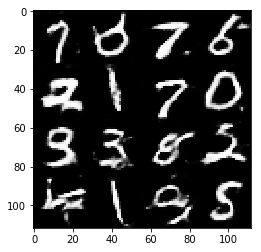

Epoch 2/2... Discriminator Loss: 1.6836... Generator Loss: 0.3613
Epoch 2/2... Discriminator Loss: 2.2117... Generator Loss: 2.7551
Epoch 2/2... Discriminator Loss: 1.3281... Generator Loss: 0.6555
Epoch 2/2... Discriminator Loss: 1.0779... Generator Loss: 1.1777
Epoch 2/2... Discriminator Loss: 1.3687... Generator Loss: 0.5593
Epoch 2/2... Discriminator Loss: 1.2257... Generator Loss: 0.6625
Epoch 2/2... Discriminator Loss: 1.2683... Generator Loss: 0.8360
Epoch 2/2... Discriminator Loss: 1.4744... Generator Loss: 0.4695
Epoch 2/2... Discriminator Loss: 1.1772... Generator Loss: 1.0014
Epoch 2/2... Discriminator Loss: 1.0806... Generator Loss: 0.8955


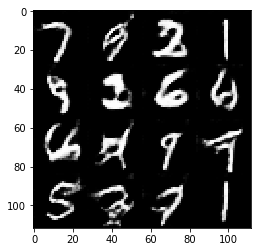

Epoch 2/2... Discriminator Loss: 1.3589... Generator Loss: 0.7303
Epoch 2/2... Discriminator Loss: 1.3398... Generator Loss: 0.7004
Epoch 2/2... Discriminator Loss: 1.2037... Generator Loss: 0.7844
Epoch 2/2... Discriminator Loss: 1.3019... Generator Loss: 0.8622
Epoch 2/2... Discriminator Loss: 1.3413... Generator Loss: 0.5385
Epoch 2/2... Discriminator Loss: 1.3246... Generator Loss: 0.5689
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.6264
Epoch 2/2... Discriminator Loss: 1.2447... Generator Loss: 0.7074
Epoch 2/2... Discriminator Loss: 1.2115... Generator Loss: 1.0345
Epoch 2/2... Discriminator Loss: 1.2466... Generator Loss: 0.6582


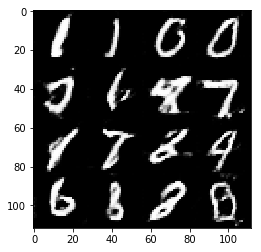

Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.6206
Epoch 2/2... Discriminator Loss: 1.1905... Generator Loss: 1.2890
Epoch 2/2... Discriminator Loss: 1.1775... Generator Loss: 0.8763
Epoch 2/2... Discriminator Loss: 1.3012... Generator Loss: 0.5809
Epoch 2/2... Discriminator Loss: 1.1879... Generator Loss: 0.9198
Epoch 2/2... Discriminator Loss: 1.3575... Generator Loss: 0.6305
Epoch 2/2... Discriminator Loss: 1.2004... Generator Loss: 0.7723
Epoch 2/2... Discriminator Loss: 1.1659... Generator Loss: 0.8436
Epoch 2/2... Discriminator Loss: 1.7652... Generator Loss: 0.3259
Epoch 2/2... Discriminator Loss: 1.3055... Generator Loss: 1.4954


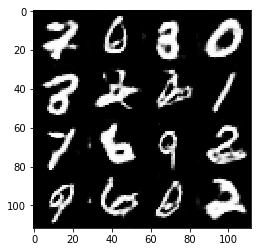

Epoch 2/2... Discriminator Loss: 1.2488... Generator Loss: 0.6631
Epoch 2/2... Discriminator Loss: 1.0881... Generator Loss: 1.1168
Epoch 2/2... Discriminator Loss: 1.1058... Generator Loss: 1.0334
Epoch 2/2... Discriminator Loss: 1.1451... Generator Loss: 0.9240
Epoch 2/2... Discriminator Loss: 1.3699... Generator Loss: 1.7627
Epoch 2/2... Discriminator Loss: 2.0000... Generator Loss: 0.2831
Epoch 2/2... Discriminator Loss: 1.4087... Generator Loss: 0.8096
Epoch 2/2... Discriminator Loss: 1.1864... Generator Loss: 0.8145
Epoch 2/2... Discriminator Loss: 1.1377... Generator Loss: 0.8334
Epoch 2/2... Discriminator Loss: 1.3289... Generator Loss: 0.6803


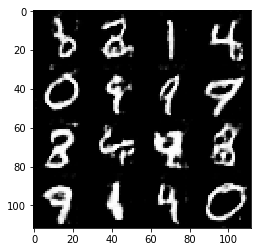

Epoch 2/2... Discriminator Loss: 1.3022... Generator Loss: 1.7010
Epoch 2/2... Discriminator Loss: 1.1912... Generator Loss: 0.7514
Epoch 2/2... Discriminator Loss: 1.1552... Generator Loss: 1.6622
Epoch 2/2... Discriminator Loss: 1.4445... Generator Loss: 0.5819
Epoch 2/2... Discriminator Loss: 1.2122... Generator Loss: 0.8918
Epoch 2/2... Discriminator Loss: 1.6366... Generator Loss: 0.3915
Epoch 2/2... Discriminator Loss: 1.1273... Generator Loss: 0.8296
Epoch 2/2... Discriminator Loss: 1.1022... Generator Loss: 1.0598
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.5390
Epoch 2/2... Discriminator Loss: 1.3481... Generator Loss: 0.5785


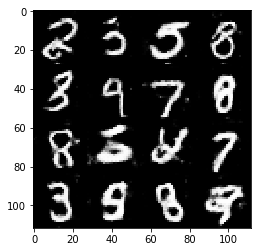

Epoch 2/2... Discriminator Loss: 1.4439... Generator Loss: 0.5496
Epoch 2/2... Discriminator Loss: 1.1633... Generator Loss: 0.9506
Epoch 2/2... Discriminator Loss: 1.2060... Generator Loss: 0.7235
Epoch 2/2... Discriminator Loss: 1.2727... Generator Loss: 0.6593
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.5773
Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 0.6533
Epoch 2/2... Discriminator Loss: 1.5941... Generator Loss: 2.0402
Epoch 2/2... Discriminator Loss: 1.3918... Generator Loss: 0.7044


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 0.6315... Generator Loss: 5.1630
Epoch 1/1... Discriminator Loss: 0.7447... Generator Loss: 1.2965
Epoch 1/1... Discriminator Loss: 0.4400... Generator Loss: 3.2940
Epoch 1/1... Discriminator Loss: 0.4840... Generator Loss: 2.6679
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.4189
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 8.9666
Epoch 1/1... Discriminator Loss: 1.9685... Generator Loss: 5.8496
Epoch 1/1... Discriminator Loss: 0.6013... Generator Loss: 2.5156
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 0.8543


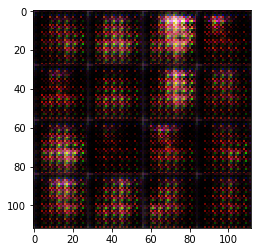

Epoch 1/1... Discriminator Loss: 0.8137... Generator Loss: 1.1265
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 1.4174
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 1.3342
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.5195
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 1.6946
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 0.8102... Generator Loss: 1.2757


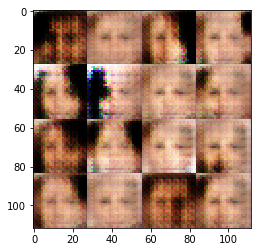

Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 1.1356
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 1.2922
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 2.0518
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.4526


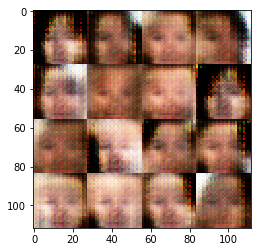

Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.5812
Epoch 1/1... Discriminator Loss: 0.8545... Generator Loss: 1.7625
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 1.9598
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 1.4364
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 1.6078
Epoch 1/1... Discriminator Loss: 0.7974... Generator Loss: 1.4244
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.9133
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.1024
Epoch 1/1... Discriminator Loss: 0.7681... Generator Loss: 1.4487


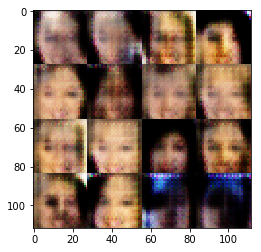

Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 0.6759... Generator Loss: 1.9321
Epoch 1/1... Discriminator Loss: 1.7398... Generator Loss: 0.3740
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 2.4204
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 1.0719
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 3.1197


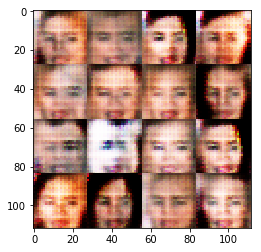

Epoch 1/1... Discriminator Loss: 0.5722... Generator Loss: 2.0271
Epoch 1/1... Discriminator Loss: 0.6005... Generator Loss: 1.9231
Epoch 1/1... Discriminator Loss: 0.8959... Generator Loss: 1.0531
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 2.3995
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.5491
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 2.5838
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 2.2483
Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 2.0936


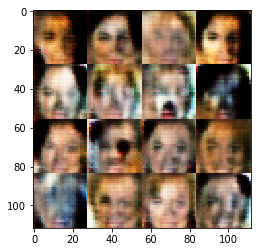

Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 3.5750... Generator Loss: 4.6746
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 1.6875
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 1.4367
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 0.9745
Epoch 1/1... Discriminator Loss: 1.8404... Generator Loss: 2.7390
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 2.9015
Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 2.0997


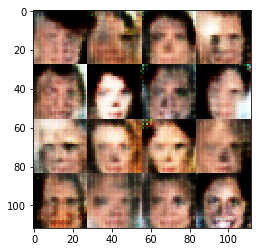

Epoch 1/1... Discriminator Loss: 0.5926... Generator Loss: 2.4023
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.4318
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 2.9976
Epoch 1/1... Discriminator Loss: 0.7570... Generator Loss: 3.0158
Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 1.4904
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 2.2740
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 2.3430
Epoch 1/1... Discriminator Loss: 0.8538... Generator Loss: 1.2351
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 0.9818


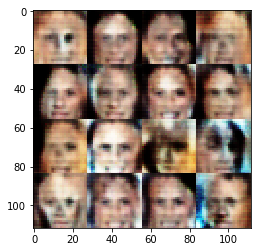

Epoch 1/1... Discriminator Loss: 1.5736... Generator Loss: 3.3377
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.8143
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 2.3563
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 2.9542
Epoch 1/1... Discriminator Loss: 0.7301... Generator Loss: 1.7212
Epoch 1/1... Discriminator Loss: 0.7441... Generator Loss: 1.4068
Epoch 1/1... Discriminator Loss: 0.7388... Generator Loss: 1.5671
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 2.2780
Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 1.2668
Epoch 1/1... Discriminator Loss: 0.4560... Generator Loss: 2.6483


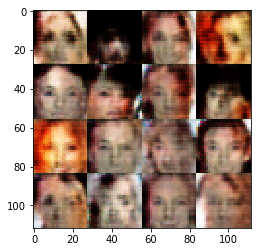

Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 2.3005... Generator Loss: 2.1877
Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 2.1049
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 2.0481
Epoch 1/1... Discriminator Loss: 0.4763... Generator Loss: 2.8990
Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 2.2968
Epoch 1/1... Discriminator Loss: 0.4603... Generator Loss: 2.5768
Epoch 1/1... Discriminator Loss: 0.4740... Generator Loss: 2.3172
Epoch 1/1... Discriminator Loss: 1.8139... Generator Loss: 0.6062


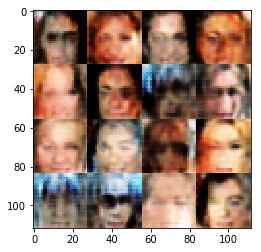

Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.7605... Generator Loss: 2.4700
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 2.6430
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 1.9439
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 0.8133... Generator Loss: 1.5233
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 0.8250... Generator Loss: 2.9349
Epoch 1/1... Discriminator Loss: 1.9901... Generator Loss: 3.3764


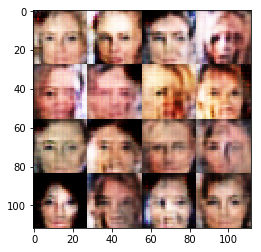

Epoch 1/1... Discriminator Loss: 0.6700... Generator Loss: 2.0886
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 2.2057
Epoch 1/1... Discriminator Loss: 0.6378... Generator Loss: 1.9027
Epoch 1/1... Discriminator Loss: 0.5138... Generator Loss: 2.2213
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 1.6544
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 2.3000
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 1.3275
Epoch 1/1... Discriminator Loss: 0.8236... Generator Loss: 3.1674
Epoch 1/1... Discriminator Loss: 0.6072... Generator Loss: 2.0143


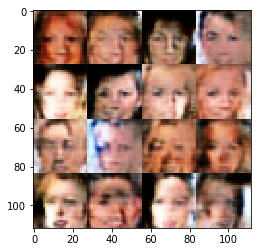

Epoch 1/1... Discriminator Loss: 0.5494... Generator Loss: 1.8926
Epoch 1/1... Discriminator Loss: 2.1113... Generator Loss: 2.8438
Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 1.6139
Epoch 1/1... Discriminator Loss: 1.6361... Generator Loss: 2.9084
Epoch 1/1... Discriminator Loss: 0.6636... Generator Loss: 1.5744
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 0.8772... Generator Loss: 1.6178
Epoch 1/1... Discriminator Loss: 0.4788... Generator Loss: 2.7417
Epoch 1/1... Discriminator Loss: 0.4393... Generator Loss: 2.8975
Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 1.3494


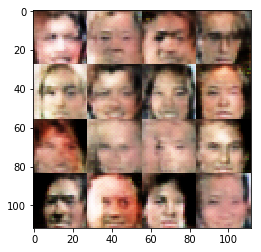

Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 1.4984
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 2.5839
Epoch 1/1... Discriminator Loss: 0.7254... Generator Loss: 1.7068
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 1.7185
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 1.0963
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.1739
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 1.0131


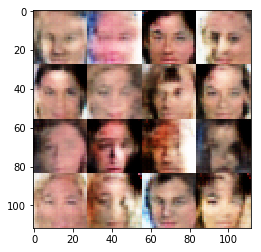

Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 1.2893
Epoch 1/1... Discriminator Loss: 0.9225... Generator Loss: 1.6083
Epoch 1/1... Discriminator Loss: 0.5520... Generator Loss: 2.1100
Epoch 1/1... Discriminator Loss: 0.4455... Generator Loss: 2.7076
Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 1.3593
Epoch 1/1... Discriminator Loss: 0.6841... Generator Loss: 1.6720
Epoch 1/1... Discriminator Loss: 2.4504... Generator Loss: 3.0833
Epoch 1/1... Discriminator Loss: 0.8030... Generator Loss: 1.1964
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 2.4778
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 1.7566


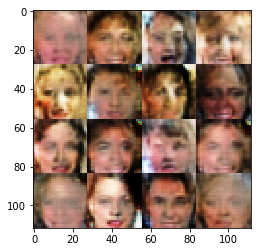

Epoch 1/1... Discriminator Loss: 2.1523... Generator Loss: 3.6593
Epoch 1/1... Discriminator Loss: 0.4097... Generator Loss: 3.0810
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 2.3792
Epoch 1/1... Discriminator Loss: 0.6772... Generator Loss: 1.4972
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 2.6195
Epoch 1/1... Discriminator Loss: 0.7377... Generator Loss: 2.3929
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.9475
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 1.0797


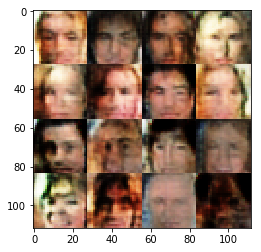

Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 1.3786
Epoch 1/1... Discriminator Loss: 0.5196... Generator Loss: 2.4157
Epoch 1/1... Discriminator Loss: 1.7267... Generator Loss: 0.3941
Epoch 1/1... Discriminator Loss: 0.5343... Generator Loss: 3.2539
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 1.9909
Epoch 1/1... Discriminator Loss: 2.3470... Generator Loss: 3.7203
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 1.7090
Epoch 1/1... Discriminator Loss: 0.5817... Generator Loss: 1.9499
Epoch 1/1... Discriminator Loss: 0.5886... Generator Loss: 1.8203
Epoch 1/1... Discriminator Loss: 0.4263... Generator Loss: 3.8564


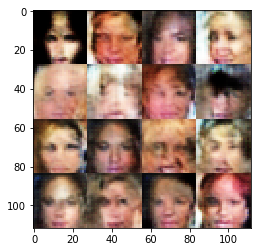

Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 1.1781
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 1.0460
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.1696
Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 2.3262
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.2847
Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 1.7288
Epoch 1/1... Discriminator Loss: 0.7183... Generator Loss: 1.5511


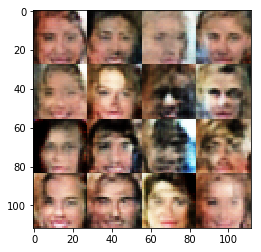

Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 0.7057... Generator Loss: 2.5764
Epoch 1/1... Discriminator Loss: 0.5660... Generator Loss: 2.3517
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 1.0521
Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 3.0251
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.9137... Generator Loss: 0.2974
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 0.7663... Generator Loss: 1.2998


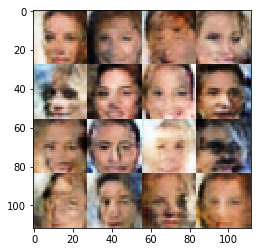

Epoch 1/1... Discriminator Loss: 0.8089... Generator Loss: 2.2463
Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 3.7299
Epoch 1/1... Discriminator Loss: 0.4056... Generator Loss: 3.3634
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 2.5791
Epoch 1/1... Discriminator Loss: 0.6741... Generator Loss: 1.4962
Epoch 1/1... Discriminator Loss: 2.1107... Generator Loss: 4.2459
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 2.8559
Epoch 1/1... Discriminator Loss: 0.4862... Generator Loss: 2.7097
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.0315


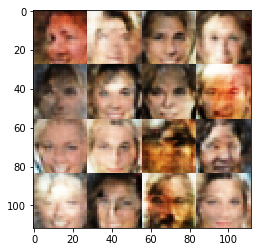

Epoch 1/1... Discriminator Loss: 0.7596... Generator Loss: 1.2720
Epoch 1/1... Discriminator Loss: 0.4977... Generator Loss: 2.3613
Epoch 1/1... Discriminator Loss: 0.7225... Generator Loss: 2.3569
Epoch 1/1... Discriminator Loss: 0.6974... Generator Loss: 1.4557
Epoch 1/1... Discriminator Loss: 2.3629... Generator Loss: 2.5038
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 1.4877
Epoch 1/1... Discriminator Loss: 0.5537... Generator Loss: 2.0582
Epoch 1/1... Discriminator Loss: 0.4663... Generator Loss: 3.4115
Epoch 1/1... Discriminator Loss: 1.6121... Generator Loss: 1.7120
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.5945


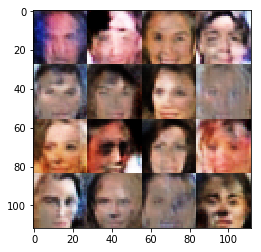

Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 1.3679
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 2.6972
Epoch 1/1... Discriminator Loss: 0.5584... Generator Loss: 1.8770
Epoch 1/1... Discriminator Loss: 0.6081... Generator Loss: 1.7319
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 3.6981
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 1.2339
Epoch 1/1... Discriminator Loss: 0.5181... Generator Loss: 2.2945
Epoch 1/1... Discriminator Loss: 0.6934... Generator Loss: 2.8404
Epoch 1/1... Discriminator Loss: 0.6769... Generator Loss: 1.9558


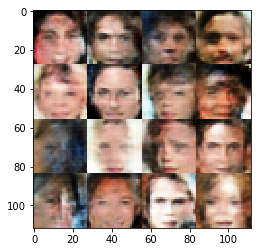

Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 1.9892
Epoch 1/1... Discriminator Loss: 0.6915... Generator Loss: 2.6201
Epoch 1/1... Discriminator Loss: 0.7659... Generator Loss: 2.5820
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 2.4224
Epoch 1/1... Discriminator Loss: 0.4871... Generator Loss: 2.3314
Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 5.5898
Epoch 1/1... Discriminator Loss: 2.5465... Generator Loss: 3.5301
Epoch 1/1... Discriminator Loss: 2.6632... Generator Loss: 0.1480
Epoch 1/1... Discriminator Loss: 0.8146... Generator Loss: 1.1712
Epoch 1/1... Discriminator Loss: 0.8096... Generator Loss: 1.4736


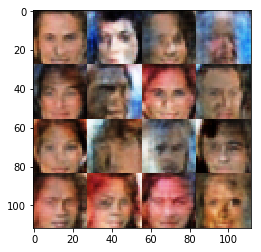

Epoch 1/1... Discriminator Loss: 0.4631... Generator Loss: 2.9818
Epoch 1/1... Discriminator Loss: 1.5758... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 2.1241
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 1.2236
Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 2.0596
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 1.3134
Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 0.5479... Generator Loss: 2.4146
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 2.7253


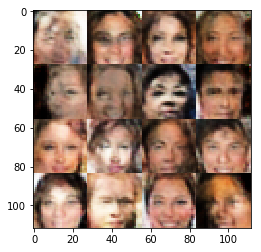

Epoch 1/1... Discriminator Loss: 0.7142... Generator Loss: 3.6154
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 2.1277
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 0.6103... Generator Loss: 2.0059
Epoch 1/1... Discriminator Loss: 0.5076... Generator Loss: 2.5185
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 1.1404
Epoch 1/1... Discriminator Loss: 0.6146... Generator Loss: 1.6639
Epoch 1/1... Discriminator Loss: 0.5877... Generator Loss: 2.0167
Epoch 1/1... Discriminator Loss: 0.4590... Generator Loss: 2.6518


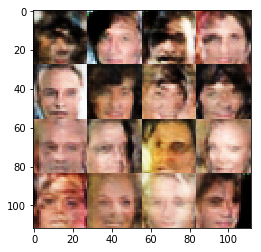

Epoch 1/1... Discriminator Loss: 0.6089... Generator Loss: 3.2806
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.0871
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 1.8335
Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 2.8836
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 0.7014... Generator Loss: 1.4514
Epoch 1/1... Discriminator Loss: 0.4386... Generator Loss: 3.3495
Epoch 1/1... Discriminator Loss: 0.5784... Generator Loss: 3.2020


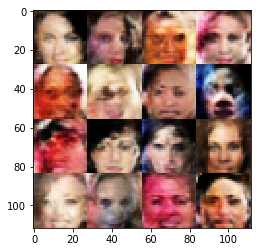

Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 1.7853
Epoch 1/1... Discriminator Loss: 1.7642... Generator Loss: 0.4012
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 3.1260
Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 1.6002
Epoch 1/1... Discriminator Loss: 0.4568... Generator Loss: 2.6109
Epoch 1/1... Discriminator Loss: 0.7379... Generator Loss: 1.2989
Epoch 1/1... Discriminator Loss: 0.6252... Generator Loss: 1.6308
Epoch 1/1... Discriminator Loss: 0.4260... Generator Loss: 3.4528
Epoch 1/1... Discriminator Loss: 0.5757... Generator Loss: 3.9304
Epoch 1/1... Discriminator Loss: 0.4702... Generator Loss: 2.6409


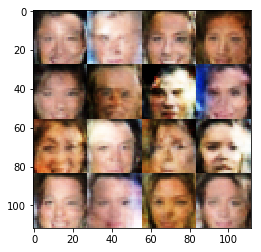

Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 1.1112
Epoch 1/1... Discriminator Loss: 0.4473... Generator Loss: 3.5820
Epoch 1/1... Discriminator Loss: 0.4652... Generator Loss: 2.4524
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.4419
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.7950
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 1.5851
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 0.6469... Generator Loss: 2.3828


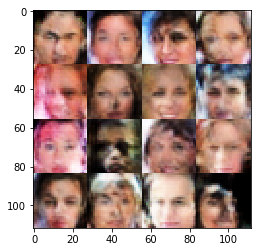

Epoch 1/1... Discriminator Loss: 0.7319... Generator Loss: 1.4973
Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 2.6920
Epoch 1/1... Discriminator Loss: 0.4817... Generator Loss: 2.3463
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 4.9984
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 3.1510
Epoch 1/1... Discriminator Loss: 0.7055... Generator Loss: 2.9044
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.9964
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 2.5764


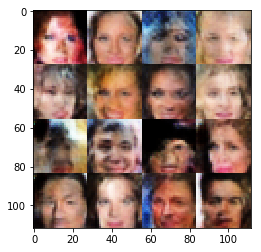

Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 2.6850
Epoch 1/1... Discriminator Loss: 0.6925... Generator Loss: 1.6710
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 2.8909
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 0.7146... Generator Loss: 2.8950
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 0.5232... Generator Loss: 2.2226
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 0.6209... Generator Loss: 2.9264
Epoch 1/1... Discriminator Loss: 0.7612... Generator Loss: 1.2411


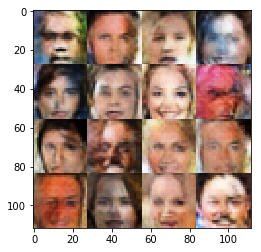

Epoch 1/1... Discriminator Loss: 0.7152... Generator Loss: 1.6049
Epoch 1/1... Discriminator Loss: 0.6562... Generator Loss: 1.6725
Epoch 1/1... Discriminator Loss: 0.4828... Generator Loss: 3.4147
Epoch 1/1... Discriminator Loss: 0.3661... Generator Loss: 5.7549
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 2.3590
Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 2.2954
Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 1.6946
Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 2.3685
Epoch 1/1... Discriminator Loss: 0.4004... Generator Loss: 3.7199
Epoch 1/1... Discriminator Loss: 0.6389... Generator Loss: 3.7442


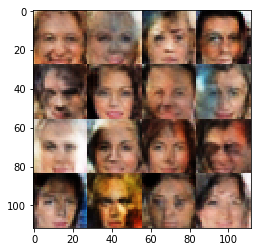

Epoch 1/1... Discriminator Loss: 1.7406... Generator Loss: 3.7212
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 3.1154
Epoch 1/1... Discriminator Loss: 1.6217... Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 0.4610... Generator Loss: 2.7253
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 0.7750... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 0.7259... Generator Loss: 3.8360


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。